# Generate SSA histograms for the TVC paper

SSA data from combined 2013-2018 dataset



In [1]:
# Standard imports
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import scipy.io as sio

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Import layer SSA median info
layer_stats = pd.read_excel('../2013_2018_combined_data/2013_2018_layer_stats.xls', sheet_name='Sheet1', index_col=0).T
ssa_med = np.asarray(layer_stats.SSA_median)
# Get histogram bins
hist_bins = pd.read_excel('../2013_2018_combined_data/2013_2018_hist_edge_stats.xls', header=None, index_col=0).T
# Pull in all SSA data - used in histogram
ssa = sio.loadmat('../2013_2018_combined_data/TVC2013_2018_SSA.mat',struct_as_record=False, squeeze_me=True)

# Code to run spatial variability simulations for the TVC paper

 - 3-layer simulations
 - spatial variability in SSA in a single layer (either FS-fresh snow, WS-wind slab or DH-depth hoar)
 - all other properties have mean value attributed to them
 - density / SSA data from combined 2013-2018 dataset
 - layer thickness vs snow depth from 2013 dataset only


In [3]:
# Define default values
density_med = np.asarray(layer_stats.density_median)
fixed_temperature = 265 # Assumption: not based on data
# Ingest spatial variability info
# Transpose to make it easier to index
hist_bins = pd.read_excel('../2013_2018_combined_data/2013_2018_hist_edge_stats.xls', header=None, index_col=0).T
hist_freq = pd.read_excel('../2013_2018_combined_data/2013_2018_hist_frequency_stats.xls', header=None, index_col=0).T
# Transpose layer_stats so can grab all layers together

# Function to calculate bin midpoint from histogram edges
# Call with e.g. calc_bin_mid(hist_bins['Histogram bin edges FS'])
def calc_bin_mid(layer):
    bin_width = layer[2]-layer[1]
    return np.asarray(layer[0:-1] + bin_width / 2.)

In [4]:
# Make a function to calc swe
def calc_swe(depth_array, layer_densities, thickness_lookup):
    swe = []
    for depth in depth_array:
        layer_thickness = np.asarray(thickness_lookup[np.around(depth,3)]).flatten()
        swe.append(np.sum(layer_thickness*layer_densities))
    return np.asarray(swe)

### Set up layer thickness by depth

Assumptions based on 2013 trench data only


In [5]:
# Fix depth range between 0.2 and 1.4m
depths = np.arange(0.05, 1.4, 0.005)
thickness_pc_fs = -44.7269 * depths + 30.1551
thickness_pc_ws = 31.8305 * depths + 47.8097
# DH percent thickness treated as constant (it hardly varies)
thickness_pc_dh = np.ones([depths.size]) * 29.6 # Actual eqn is 1.4821 * depths + 29.0613
# Make FS% zero if < 0
thickness_pc_fs[thickness_pc_fs < 0] = 0
# Derive WS thickness from DH and FS
thickness_pc_ws = 100 - thickness_pc_fs - thickness_pc_dh
thickness = np.column_stack((np.multiply(thickness_pc_fs, depths), np.multiply(thickness_pc_ws, depths), np.multiply(thickness_pc_dh, depths)))
thickness = thickness * 1e-2 # % percent converted to fraction of 1

### Set up smrt configuration

For now just use single SMRT config: EXP-IBA


In [6]:
# SMRT imports
from smrt import make_snowpack, make_model, sensor
from smrt.substrate.reflector_backscatter import make_reflector
from smrt.core.globalconstants import DENSITY_OF_ICE, FREEZING_POINT
from smrt.utils import dB, invdB

# Make model
imodel = make_model("iba","dort")

# Make sensor
scatt = sensor.active([13.4e9, 17.2e9], 35)

# Make a substrate
# 0.05 = -13dB
sub = make_reflector(temperature=265, specular_reflection=0.,
                           backscattering_coefficient={'VV': 0.05, 'HH': 0.05})

## Layer spatial variability

### Function to calculate 'Truth' simulations

In [7]:
def forward_simulation(lay, bins=hist_bins, ssa=ssa_med, density=density_med, 
                       temperature=fixed_temperature, depths=depths, thickness=thickness):
    # Construct truth pex array
    truth_pex = []
    for sp in range(5):
        ssa_var = deepcopy(ssa) # Need to leave original ssa intact
        if lay == 0:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges FS'])[sp]
        elif lay == 1:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges WS'])[sp]
        elif lay == 2:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges DH'])[sp]
        else:
            print ('layer not known')
        truth_pex.append(0.75 * (4.*(1.0-density/DENSITY_OF_ICE)/(ssa_var*DENSITY_OF_ICE)))
        
    # Construct list of snowpacks
    snowpack0 = []
    snowpack1 = []
    snowpack2 = []
    snowpack3 = []
    snowpack4 = []

    for d in range(len(depths)):
        firstlay = 1 # Default top layer is WS unless
        if thickness[d,0] > 0: # First column is FS
            firstlay = 0 # Include FS layer
        snowpack0.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[0][firstlay:3], substrate=sub))
        snowpack1.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[1][firstlay:3], substrate=sub))
        snowpack2.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[2][firstlay:3], substrate=sub))
        snowpack3.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[3][firstlay:3], substrate=sub))
        snowpack4.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[4][firstlay:3], substrate=sub))
        
    # Calc SWE
    SWE_truth_mm = [ np.sum(1000*thickness[d]*(density/1000)) for d in range(len(depths))]

    # Run simulations
    res0 = imodel.run(scatt, snowpack0, snowpack_dimension=('swe', SWE_truth_mm))
    res1 = imodel.run(scatt, snowpack1, snowpack_dimension=('swe', SWE_truth_mm))
    res2 = imodel.run(scatt, snowpack2, snowpack_dimension=('swe', SWE_truth_mm))
    res3 = imodel.run(scatt, snowpack3, snowpack_dimension=('swe', SWE_truth_mm))
    res4 = imodel.run(scatt, snowpack4, snowpack_dimension=('swe', SWE_truth_mm))
    
    # Calc layer spatial variable weightings i.e. convert to fractional
    if lay == 2:
        weights = np.asarray(hist_freq['Histogram bin frequency DH']) / np.sum(hist_freq['Histogram bin frequency DH'])
    elif lay == 1:
        weights = np.asarray(hist_freq['Histogram bin frequency WS']) / np.sum(hist_freq['Histogram bin frequency WS'])
    elif lay == 0:
        weights = np.asarray(hist_freq['Histogram bin frequency FS']) / np.sum(hist_freq['Histogram bin frequency FS'])
    else:
        print ('layer not known')
        
    # Aggregate results:
    # Weighted scene
    sigmaVV_agg = (weights[0] * res0.sigmaVV()+ weights[1] * res1.sigmaVV() + weights[2] * res2.sigmaVV()
                   + weights[3] * res3.sigmaVV() + weights[4] * res4.sigmaVV())

    # 17-13 sigmaVV difference
    sigma_truth_diff = sigmaVV_agg.sel(frequency=17.2e9)-sigmaVV_agg.sel(frequency=13.4e9)
    return(sigma_truth_diff)

## Homogeneous retrieval snowpack

### Function to retrieve SWE from backscatter difference
3-layer retrieval so 'perfect' retrieval theoretically possible.

In [8]:
def retrieval(lay, sigma_truth_diff, ssa=ssa_med, density=density_med, 
                       temperature=fixed_temperature, depths=depths, thickness=thickness):
    # create the errors. SSA ± 50% out
    #SSArange = np.arange(0.6,1.42,0.02) * ssa[lay]
    SSArange = np.arange(0.75,1.27,0.02) * ssa[lay]
    pex_range =  np.array([0.75 * (4.*(1.0-(density/DENSITY_OF_ICE))/(ssa*DENSITY_OF_ICE))]*len(SSArange))    
    pex_range.T[lay] = 0.75 * (4.*(1.0-(density[lay]/DENSITY_OF_ICE))/(SSArange*DENSITY_OF_ICE))
    
    # Create unknown snowpacks. Loop 1: Depth, Loop 2 p_ex_error. Density fixed
    # i.e. depth held constant (slow loop) whilst p_ex changed (fast loop)
    # depth is increasing, pex decreasing
    # Snow layers in TVC_trenches are numbered from the top as 1=Fresh Snow, 2=Wind Slab, 3=Depth Hoar
    # SMRT layers are numbered from 1 = top also.
    # Need to have 3 layers unless no fresh snow
    snowpacks_pexerr = []
    for s in range(len(depths)):
        for p in range(len(pex_range)):
            firstlay = 1 # Default top layer is WS unless
            if thickness[s,0] > 0: # First column is FS
                firstlay = 0 # Include FS layer 
            snowpack = make_snowpack(thickness[s, firstlay:3], 
                                "exponential",
                                density=density[firstlay:3],
                                corr_length=pex_range[p][firstlay:3],
                                temperature=fixed_temperature,
                                substrate=sub)
            snowpacks_pexerr.append(snowpack)
            
    # Get results out for simulated snowpacks
    res_pexerr = imodel.run(scatt, snowpacks_pexerr)
    sigma_diff_pexerr = res_pexerr.sigmaVV(frequency=17.2e9) - res_pexerr.sigmaVV(frequency=13.4e9)
    # Reshape results
    sigma_diff_pexerr_reshape = (np.reshape(sigma_diff_pexerr.data,(len(depths), len(pex_range))))
    
    # Do depth retrieval
    # Don't see loop over retrieved snow depth: Depth information included in sigma_diff arrays
    # Sigma_truth_diff is the aggregated backscatter
    ret_depth = np.empty([len(depths), len(pex_range)])
    for true_depth in range(len(depths)):
        for p in range(len(pex_range)):
            CF_td = np.square(sigma_diff_pexerr_reshape[:,p] - sigma_truth_diff.values[true_depth])
            #if np.around(depths[true_depth],1) == 0.7:
            #    print (sigma_diff_pexerr_reshape[:,p], sigma_truth_diff.values[true_depth])
            # Find depth index with minimum CF for a given microstructure
            d_index = np.where(CF_td == np.min(CF_td))[0] # [0] accesses index
            ret_depth[true_depth, p] = depths[d_index]
            
    # create dictionary #Change 
    thickness_lookup = dict(zip(np.around(depths,3), zip(thickness)))

    # Calc SWE retrieval error #LEANNE ADDED swe_calc and swe_truth
    swe_ERROR = []
    for p in range(len(pex_range)):
        swe_ERROR.append(calc_swe(ret_depth[:,p],density,thickness_lookup) - calc_swe(depths,density,thickness_lookup))
    # Turn into array for plotting, and transpose for plotting
    swe_ERROR = np.asarray(swe_ERROR).T
    return (SSArange, swe_ERROR)


In [9]:
# Calc FS spatial variability effect
fs_truth = forward_simulation(0)
fs_ssa, fs_swe_ret = retrieval(0, fs_truth)

active model is not yet fully implemented, need modification for the third component


In [10]:
# Calc WS spatial variability effect
ws_truth = forward_simulation(1)
ws_ssa, ws_swe_ret = retrieval(1, ws_truth)

In [11]:
# Calc DH spatial variability effect
dh_truth = forward_simulation(2)
dh_ssa, dh_swe_ret = retrieval(2, dh_truth)

<IPython.core.display.Javascript object>


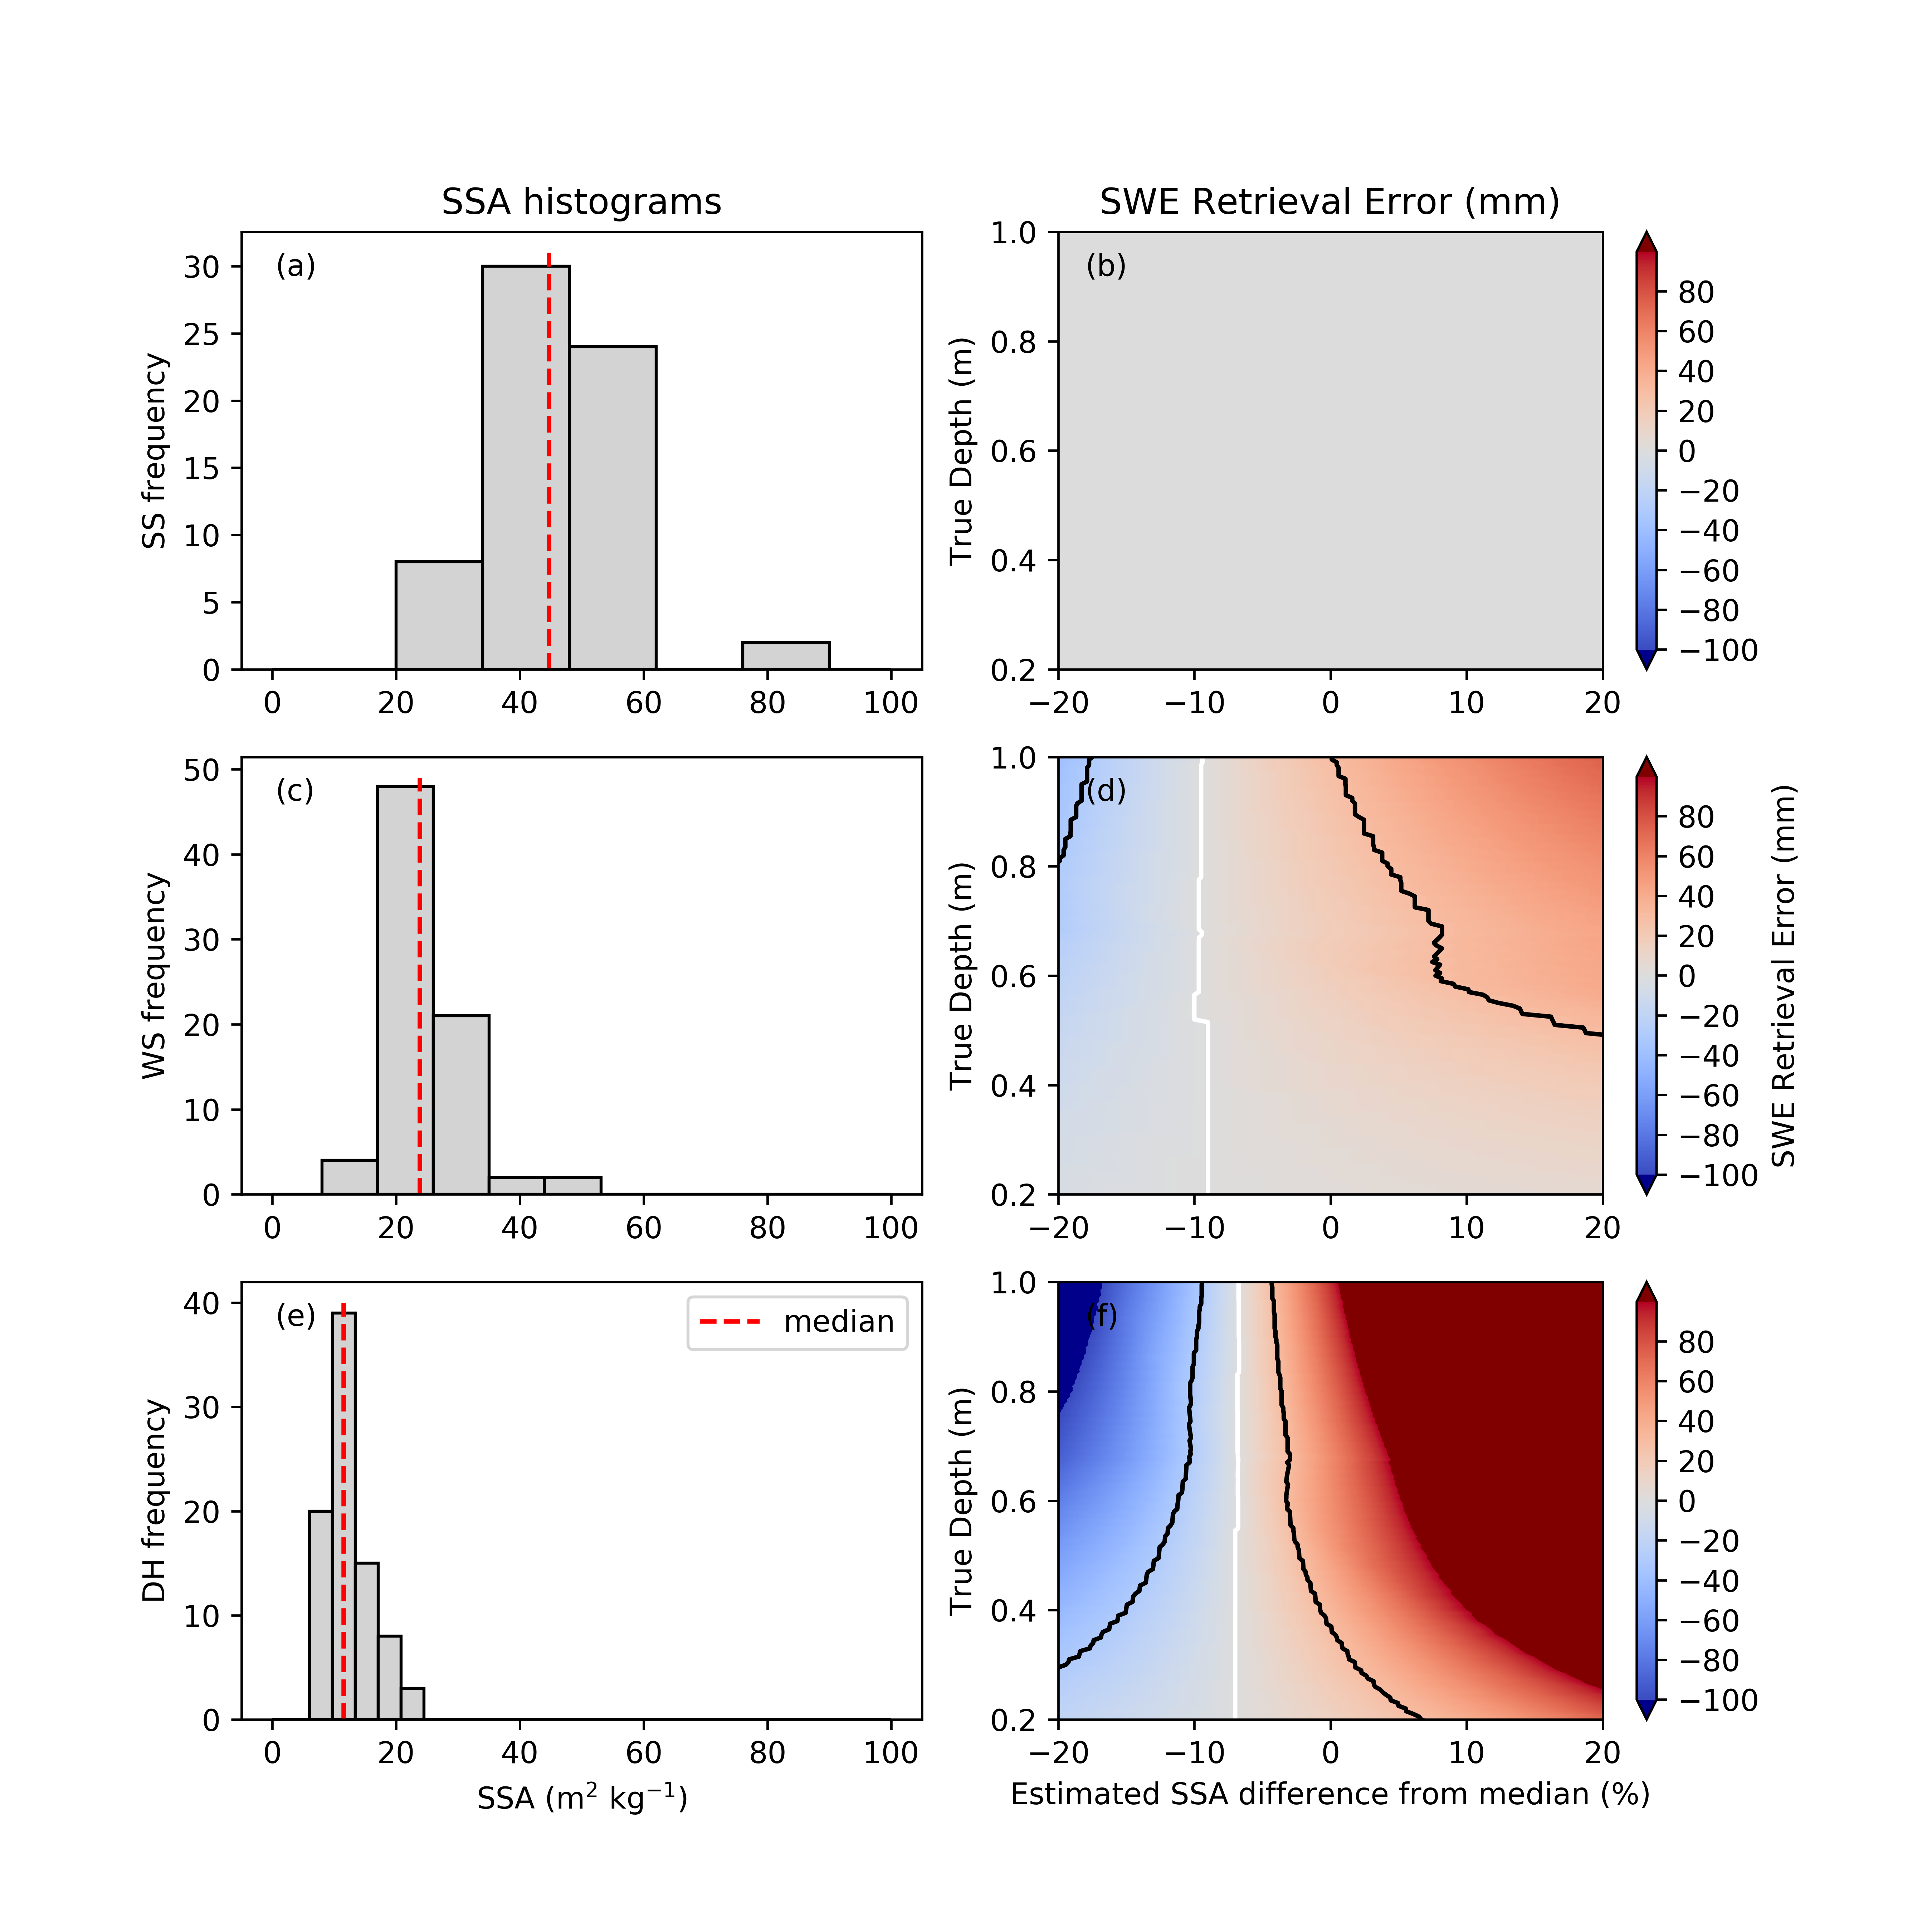

Text(0.05, 0.9, '(f)')

In [109]:
# Set up figure
plt.figure(num=None, figsize=(9, 9), dpi=300, facecolor='w', edgecolor='k')

colmap = plt.cm.get_cmap('coolwarm')
colunder = 'darkblue'
colover = 'maroon'

# SS (previously named FS) histogram 
# Need to extend histogram bin range to cover SS, WS, DH. Set between 0 and 100 for simplicity.
ax1 = plt.subplot(3,2,1)
ax1.hist(ssa['SSA_FS'], [0] + list(hist_bins['Histogram bin edges FS']) + [100], edgecolor='k', facecolor='lightgrey')
ax1.plot(32*[ssa_med[0]],np.arange(32),'r--' )
ax1.set_ylabel('SS frequency')
ax1.set_title('SSA histograms')

# SS (previously named FS) error graph
ax2 = plt.subplot(3,2,2)
lay = 0
SSA_labels = 100 * (fs_ssa-ssa_med[lay]) / ssa_med[lay]
cbarlevels=np.arange(-100, 100, 0.2)
fs_plot = ax2.contourf(SSA_labels,depths,fs_swe_ret,cbarlevels,cmap=colmap, extend='both')

fs_plot.cmap.set_under(colunder)
fs_plot.cmap.set_over(colover)# Use ,levels=np.linspace(-30,30,15) to constrain contour plot
fscbar=plt.colorbar(fs_plot, ax=ax2)
#fscbar.ax.set_ylabel('SWE Retrieval Error (mm)')
#plthandle1a=ax2.contour(SSA_labels,depths,fs_swe_ret,[-30],colors=('k'))
#plthandle1a=ax2.contour(SSA_labels,depths,fs_swe_ret,[30],colors=('k'))
#plthandle1a=ax2.contour(SSA_labels,depths,fs_swe_ret,[0],colors=('w'))

ax2.set_ylabel('True Depth (m)')
#ax2.set_xlabel('A priori SSA difference from median (%)')
ax2.set_title('SWE Retrieval Error (mm)')
#ax2.set_xticks( rotation=30 )
ax2.set_xlim(-20, 20)
ax2.set_ylim(0.2, 1)

# WS histogram
# NB maximum WS SSA is on histogram edge. Modify edge from 53.0 to 53.1 
# to ensure point does not sit in higher bin category in plot
extendedrange = [0] + list(hist_bins['Histogram bin edges WS']) + [100]
extendedrange[-2] = 53.1
ax3 = plt.subplot(3,2,3)
ax3.hist(ssa['SSA_WS'], extendedrange, edgecolor='k', facecolor='lightgrey')
ax3.plot(50*[ssa_med[1]],np.arange(50),'r--' )
ax3.set_ylabel('WS frequency')

# WS error graph
ax4 = plt.subplot(3,2,4)
lay = 1
SSA_labels = 100 * (ws_ssa-ssa_med[lay]) / ssa_med[lay]
cbarlevels=np.arange(-100, 100, 0.2)
ws_plot = ax4.contourf(SSA_labels,depths,ws_swe_ret,cbarlevels,cmap=colmap, extend='both')

ws_plot.cmap.set_under(colunder)
ws_plot.cmap.set_over(colover)
wscbar=plt.colorbar(ws_plot, ax=ax4)
wscbar.ax.set_ylabel('SWE Retrieval Error (mm)')
plthandle1a=ax4.contour(SSA_labels,depths,ws_swe_ret,[-30],colors=('k'), linestyles='solid')
plthandle1a=ax4.contour(SSA_labels,depths,ws_swe_ret,[30],colors=('k'))
plthandle1a=ax4.contour(SSA_labels,depths,ws_swe_ret,[0],colors=('w'))

ax4.set_ylabel('True Depth (m)')
ax4.set_xlim(-20, 20)
ax4.set_ylim(0.2, 1)

# DH histogram
ax5 = plt.subplot(3,2,5)
ax5.hist(ssa['SSA_DH'], [0] + list(hist_bins['Histogram bin edges DH']) + [100], edgecolor='k', facecolor='lightgrey')
ax5.plot(41*[ssa_med[2]],np.arange(41),'r--', label='median')
ax5.set_xlabel('SSA (m$^2$ kg$^{-1}$)')
ax5.set_ylabel('DH frequency')
ax5.legend()


# DH error graph
ax6 = plt.subplot(3,2,6)
lay = 2
SSA_labels = 100 * (dh_ssa-ssa_med[lay]) / ssa_med[lay]
cbarlevels=np.arange(-100, 100, 0.2)
dh_plot = ax6.contourf(SSA_labels,depths,dh_swe_ret,cbarlevels,cmap=colmap, extend='both')

dh_plot.cmap.set_under(colunder)
dh_plot.cmap.set_over(colover)
dhcbar=plt.colorbar(dh_plot, ax=ax6)
plthandle1a=ax6.contour(SSA_labels,depths,dh_swe_ret,[-30],colors=('k'), linestyles='solid')
plthandle1a=ax6.contour(SSA_labels,depths,dh_swe_ret,[30],colors=('k'))
plthandle1a=ax6.contour(SSA_labels,depths,dh_swe_ret,[0],colors=('w'))

ax6.set_ylabel('True Depth (m)')
ax6.set_xlabel('Estimated SSA difference from median (%)')
ax6.set_xlim(-20, 20)
ax6.set_ylim(0.2, 1)

# Label graphs (a) to (f)
ax1.text(0.05,0.9,'(a)', transform=ax1.transAxes)
ax2.text(0.05,0.9,'(b)', transform=ax2.transAxes)
ax3.text(0.05,0.9,'(c)', transform=ax3.transAxes)
ax4.text(0.05,0.9,'(d)', transform=ax4.transAxes)
ax5.text(0.05,0.9,'(e)', transform=ax5.transAxes)
ax6.text(0.05,0.9,'(f)', transform=ax6.transAxes)

In [110]:
thickness_lookup = dict(zip(np.around(depths,3), zip(thickness)))
test = calc_swe(depths,density_med,thickness_lookup)

max(dh_swe_ret[:,13] / test)

0.39668512983405535

In [111]:
np.round(dh_swe_ret[:,-4] / test,2)

array([1.15, 1.14, 1.14, 1.22, 1.21, 1.2 , 1.2 , 1.2 , 1.19, 1.19, 1.25,
       1.24, 1.24, 1.24, 1.24, 1.23, 1.28, 1.28, 1.27, 1.27, 1.27, 1.31,
       1.31, 1.31, 1.31, 1.31, 1.34, 1.34, 1.34, 1.34, 1.37, 1.37, 1.37,
       1.39, 1.39, 1.39, 1.39, 1.42, 1.42, 1.42, 1.44, 1.44, 1.44, 1.47,
       1.47, 1.47, 1.49, 1.49, 1.51, 1.51, 1.51, 1.53, 1.54, 1.53, 1.54,
       1.53, 1.54, 1.53, 1.53, 1.53, 1.53, 1.52, 1.53, 1.52, 1.53, 1.52,
       1.53, 1.52, 1.52, 1.52, 1.52, 1.53, 1.52, 1.52, 1.51, 1.52, 1.51,
       1.51, 1.52, 1.51, 1.51, 1.52, 1.51, 1.51, 1.51, 1.51, 1.51, 1.51,
       1.5 , 1.51, 1.51, 1.51, 1.5 , 1.51, 1.51, 1.51, 1.5 , 1.5 , 1.51,
       1.51, 1.51, 1.5 , 1.5 , 1.5 , 1.5 , 1.51, 1.48, 1.45, 1.43, 1.41,
       1.38, 1.36, 1.33, 1.31, 1.29, 1.27, 1.25, 1.22, 1.2 , 1.18, 1.16,
       1.14, 1.12, 1.1 , 1.08, 1.07, 1.05, 1.04, 1.02, 1.01, 0.99, 0.98,
       0.96, 0.95, 0.94, 0.92, 0.91, 0.9 , 0.89, 0.87, 0.86, 0.85, 0.84,
       0.82, 0.81, 0.8 , 0.79, 0.78, 0.77, 0.75, 0.